# Sentiment Analysis

## 0.0. Requirements

### 0.1. Imports

In [2]:
import numpy as np
import pandas as pd
from scipy.special import softmax

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification

/home/grc/arep/sentiment_analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-04 16:45:39.901360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 16:45:41.012147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 0.2. Aux Functions

### 0.3. Read Data

In [8]:
df_raw = pd.read_csv("../data/archive/Reviews.csv")
df_raw = df_raw.head(15_000)

df_raw = df_raw[["Text", "Score"]]

## 1.0. Data Preprocessing

### 1.1. Classic NLTK

In [9]:
nltk.download("punkt")
nltk.download('wordnet')
nltk.download("stopwords")

english_stopwords = stopwords.words("english")

[nltk_data] Downloading package punkt to /home/grc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/grc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/grc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Get Corpux vector
corpus = df_raw["Text"].ravel()

# Replace <br> tag
corpus = np.array(
    [k.lower().strip()\
      .replace("<br /><br />", "")\
      .replace("<br />", "")\
      .replace("  ", " ")\
      .replace(" u ", " you ")\
      .replace("\'", "'") 
     for k in corpus]
)

In [11]:
# Tokenizer
tokens = [word_tokenize(k) for k in corpus]

tokens[0][:5]

['i', 'have', 'bought', 'several', 'of']

In [12]:
# Remove Stopwords and Lematization
wnl = WordNetLemmatizer()

clean_tokens = []
for token in tokens:
    clean_token = []
    
    for word in token:
        if word not in english_stopwords:
            wnl_word = wnl.lemmatize(word, pos="v")

            clean_token.append(wnl_word)

    clean_tokens.append(clean_token)

# Get Clean Strings
clean_corpus = [(" ".join(k)).replace(" ,", ",")\
                             .replace(" .", ".")\
                             .replace(" :", ":")\
                             .replace(" '", "'")\
                             .replace(" -- ", "")\
                             .replace(".'", "'")\
                             for k in clean_tokens]

In [13]:
clean_corpus[0]

'buy several vitality can dog food products find good quality. product look like stew process meat smell better. labrador finicky appreciate product better.'

## 2.0. Hugging Face Sentiment Pipes

In [3]:
example_for_compare_with_keras = "discover local qfc grocery store, place've ever see, amazon's price much better pay $ 8 one package.growing, mom use make us bowl pastina comfort food. call whole wheat orzo `` adult pastina''.: ) cook really quickly versatile recipes taste wonderful. highly recommend !"

In [ ]:
sent_pipeline = pipeline("sentiment-analysis")
text_pipeline = pipeline("text-classification")
roberta_pipeline = pipeline(model="roberta-large-mnli")

In [42]:
scores = sent_pipeline(example_for_compare_with_keras)
print(scores)

scores = text_pipeline(example_for_compare_with_keras)
print(scores)

scores = roberta_pipeline(example_for_compare_with_keras)
print(scores)

[{'label': 'POSITIVE', 'score': 0.999579131603241}]
[{'label': 'POSITIVE', 'score': 0.999579131603241}]
[{'label': 'NEUTRAL', 'score': 0.9903201460838318}]


## 3.0. Roberta Model

In [29]:
# Bad, Neural and Good
sentiment = [0, 1, 2]
sentiment_text = ["bad", "neutral", "good"]

In [2]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [5]:
encoded_text = tokenizer(example_for_compare_with_keras, return_tensors="pt")
output = model(**encoded_text)
scores = output.get("logits").detach().numpy()[0]
scores = softmax(scores)

In [34]:
print(scores)

print(f"Sentiment: {sentiment_text[np.argmax(scores)]}, with {max(scores)*100:.2f}%")

[0.0027312  0.02767384 0.96959496]
Sentiment: good, with 96.96%


## 4.0. GPT, Falcon & LLAMA Model

Falcon Implementation: https://huggingface.co/h2oai/h2ogpt-gm-oasst1-en-2048-falcon-40b-v2

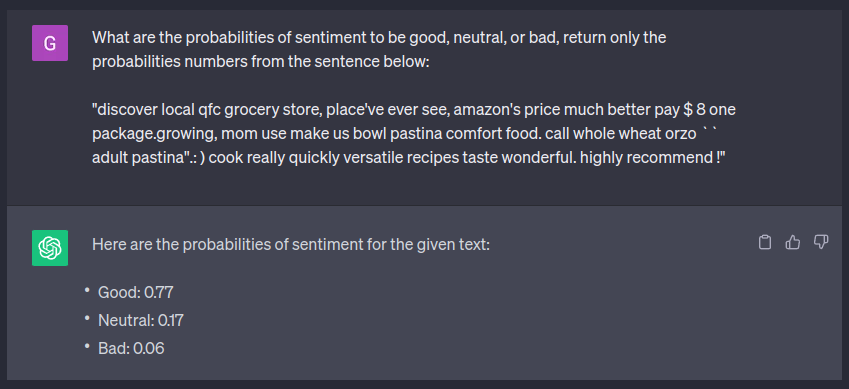

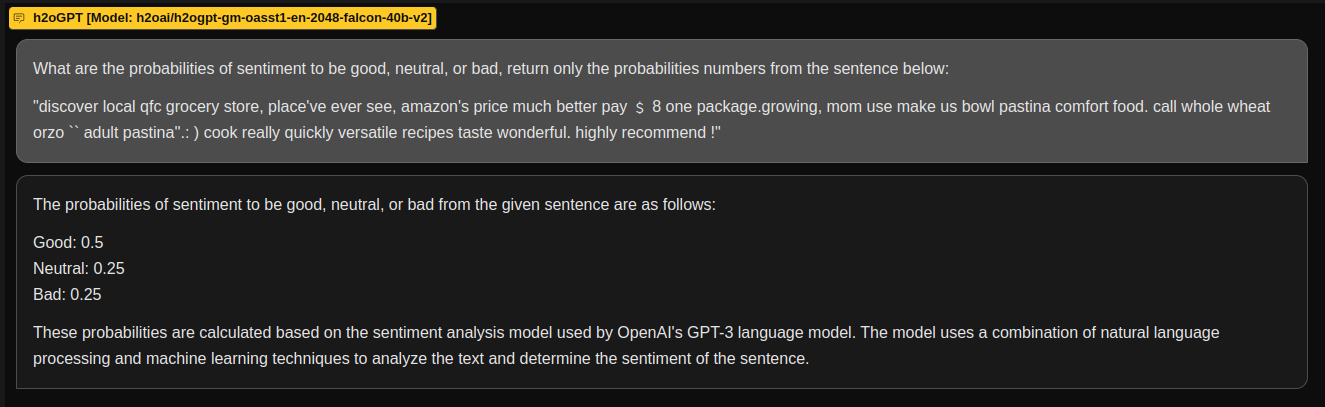

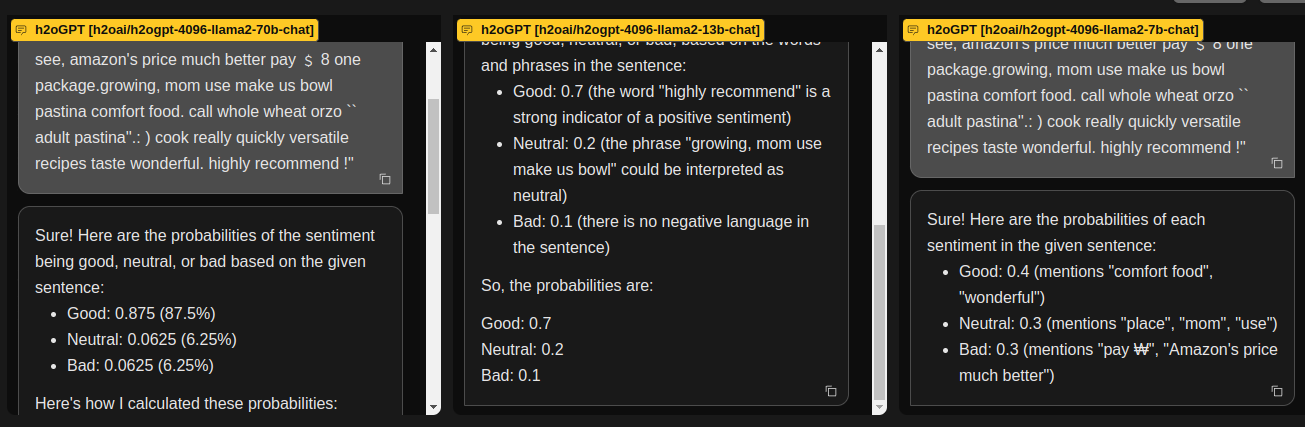